<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/03-image-vision/02_classification_with_fine_tuning_on_5flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification with Fine-Tuning

In this notebook, we will discuss how to create an embedding (as distinct from a classification model), and how to use the embedding to train models on different datasets using two different approaches, transfer learning and fine-tuning.

Traditional fully connected neural network layers perform poorly on
images because they do not take advantage of the fact that adjacent pixels are highly correlated.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/03-image-vision/images/1.png?raw=1' width='800'/>

>Applying a fully connected layer to all the pixels of an image treats the pixels as independent inputs and ignores that images have adjacent pixels working together to create shapes.

Moreover, fully connecting multiple layers does not make any special provisions for the 2D hierarchical nature of images. Pixels close to each other work together to create shapes (such as lines and arcs), and these shapes themselves
work together to create recognizable parts of an object (such as the stem and
petals of a flower).



## Setup

In [ ]:
!pip install --quiet keras-adamw

In [ ]:
import os
os.environ['TF_KERAS'] = '1' # for AdamW
from keras_adamw import AdamW

In [ ]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.6.0


In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

TPU or GPU detection

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

###Configuration

Learning rate schedule: 1e-05 to 0.0008 to 0.000116


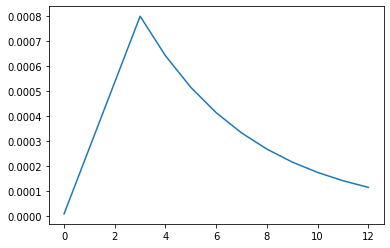

In [ ]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_5_tfr"

# Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
EPOCHS = 13

# Learning rate schedule for fine-tuning: use trainable=True (best validation accuracy 0.91)
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.000025 * strategy.num_replicas_in_sync
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 3
#LR_SUSTAIN_EPOCHS = 1
#LR_EXP_DECAY = .8

# Learning rate schedule for fine-tuning with AdamW: use trainable=True (best validation accuracy 0.92)
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

# learning rate schedule for transfer learning: use trainable=False (best validation accuracy 0.90)
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.00075 * strategy.num_replicas_in_sync #(Note: 0.00007 with trainable=True to replicate graph in book)
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 0
#LR_SUSTAIN_EPOCHS = 0
#LR_EXP_DECAY = .8

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]] + '/*.tfrec'
filenames = tf.io.gfile.glob(GCS_PATH)
validation_split = 0.19
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

###Visualization utilities

data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    #plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

###Datasets

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
TRAIN_STEPS = NUM_TRAINING_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 2990 training images, 680 validation images


###Dataset visualizations (5 flowers)

In [ ]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(64, 224, 224, 3) (64,)
(64, 224, 224, 3) (64,)
(64, 224, 224, 3) (64,)
Training data label examples: [2 4 4 ... 3 1 0]


In [ ]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

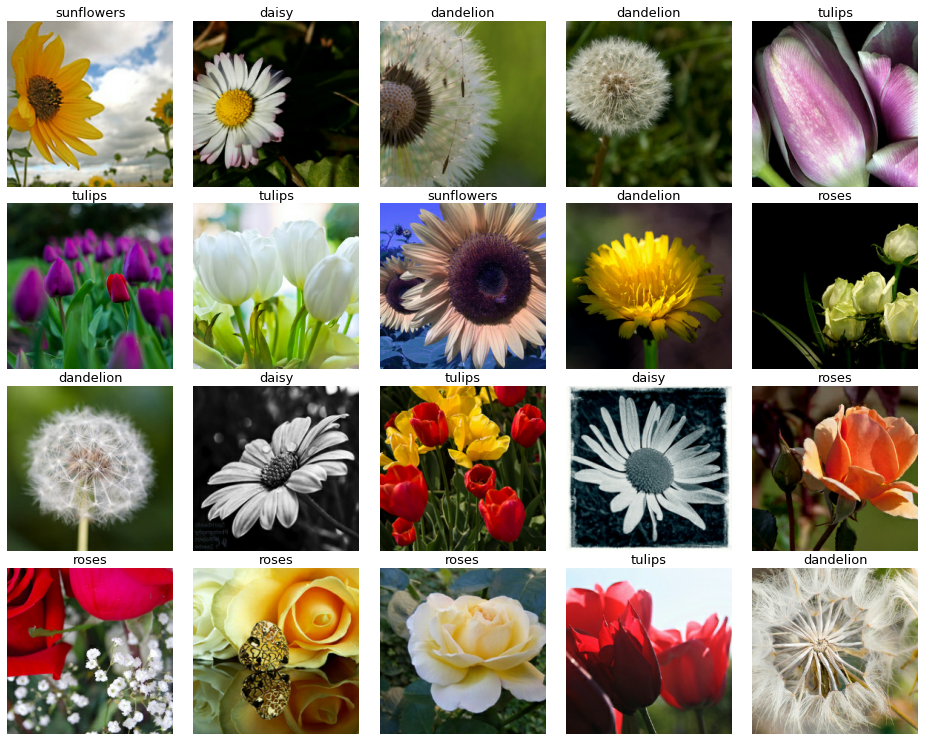

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

##Fine-Tuning

In many instances, we might be able to get better results if we allow our training loop
to also adapt the pretrained layers. This technique is called fine-tuning. The pretrained
weights are used as initial values for the weights of the neural network (normally,
neural network training starts with the weights initialized to random values).

In theory, all that is needed to switch from transfer learning to fine-tuning is to flip
the trainable flag from False to True when loading a pretrained model and train on your data.

The training curve here shows that the model mathematically converges. However, its
performance on the validation data is poor and initially gets worse before somewhat
recovering. With a learning rate set too high, the pretrained weights are being
changed in large steps and all the information learned during pretraining is lost.
Finding a learning rate that works can be tricky—set the learning rate too low and
convergence is very slow, too high and pretrained weights are lost.

There are two techniques that can be used to solve this problem: 

- a learning rate schedule 
- a layer-wise learning rates


###Learning rate schedule

The most traditional learning rate schedule when training neural networks is to have
the learning rate start high and then decay exponentially throughout the training.
When fine-tuning a pretrained model, a warm-up ramp period can be added.

###Differential learning rate

Another good trade-off is to apply a differential learning rate, whereby we use a low
learning rate for the pretrained layers and a normal learning rate for the layers of our
custom classification head.

In fact, we can extend the idea of a differential learning rate within the pretrained layers
themselves—we can multiply the learning rate by a factor that varies based on layer depth, gradually increasing the per-layer learning rate and finishing with the full
learning rate for the classification head.

In order to apply a complex differential learning rate like this in Keras, we need to
write a custom optimizer. But fortunately, an open source Python package called
AdamW exists that we can use by specifying a learning rate multiplier for different
layers.

```python
mult_by_layer={
  'block1_': 0.1,
  'block2_': 0.15,
  'block3_': 0.2,
  ... # blocks 4 to 11 here
  'block12_': 0.8,
  'block13_': 0.9,
  'block14_': 0.95,
  'flower_prob': 1.0, # for the classification head
}
optimizer = AdamW(lr=LR_MAX, model=model, lr_multipliers=mult_by_layer)
```

With both the per-layer learning rate and a learning rate schedule with a ramp-up, we
can push the accuracy of a fine-tuned MobileNetV2 on the tf_flowers (5-flowers)
dataset to 0.92, versus 0.91 with the ramp-up only and 0.9 with transfer learning only.

The gains from fine-tuning here are small because the tf_flowers dataset is tiny. We
need a more challenging benchmark for the advanced architectures we are about to
explore.

In [ ]:
with strategy.scope():
  pretrained_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=[*IMAGE_SIZE, 3])

  pretrained_model.trainable = True  # fine-tuning

  model = tf.keras.Sequential([
     # convert image format from int [0,255] to the format expected by this model
     tf.keras.layers.Lambda(lambda data: preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
     pretrained_model,      
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(16, activation="relu", name="flower_dense"),
     tf.keras.layers.Dense(len(CLASSES), activation="softmax", name="flower_probability")                
  ])

  # for pretrained layers
  mult = 0.04
  mult_by_layer = {
      # Clasification head
      'flower_prob': 1.0,
      'flower_dense': 1.0,
      # Pretrained layers
      'block_1_': 0.02 * mult,
      'block_2_': 0.04 * mult,
      'block_3_': 0.06 * mult,
      'block_4_': 0.08 * mult,
      'block_5_': 0.1 * mult,
      'block_6_': 0.15 * mult,
      'block_7_': 0.2 * mult,
      'block_8_': 0.25 * mult,
      'block_9_': 0.3 * mult,
      'block_10_': 0.35 * mult,
      'block_11_': 0.4 * mult,
      'block_12_': 0.5 * mult,
      'block_13_': 0.6 * mult,
      'block_14_': 0.7 * mult,
      'block_15_': 0.8 * mult,
      'block_16_': 0.9 * mult,
      # these layers do not have stable identifiers in tf.keras.applications.MobileNetV2
      'conv': 0.5 * mult,
      'Conv': 0.5 * mult
  }

  optimizer = AdamW(learning_rate=LR_MAX, model=model, lr_multipliers=mult_by_layer)

model.compile(
    optimizer='adam',
    #optimizer=optimizer, 
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
    steps_per_execution=8
)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
flower_dense (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_probability (Dense)   (None, 5)                 85        
Total params: 2,278,565
Trainable params: 2,244,453
Non-trainable params: 34,112
_________________________________________________________________
None


In [ ]:
history = model.fit(get_training_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    validation_data=get_validation_dataset(),
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

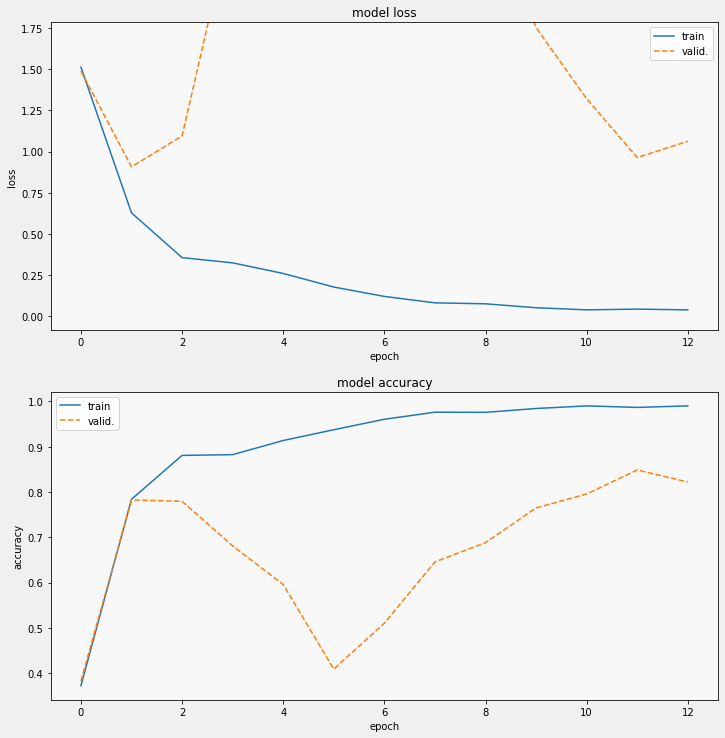

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,1.7])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

###Confusion matrix

In [ ]:
# since we are splitting the dataset and iterating separately on images and labels, order matters.
cmdataset = get_validation_dataset(ordered=True) 
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (680,) [1 1 2 ... 0 3 4]
Predicted labels:  (680,) [1 1 2 ... 0 3 4]


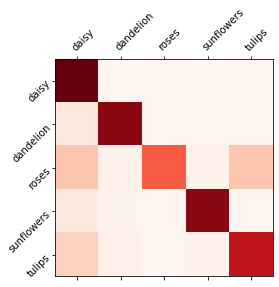

f1 score: 0.813, precision: 0.851, recall: 0.820


In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

###Visual validation

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

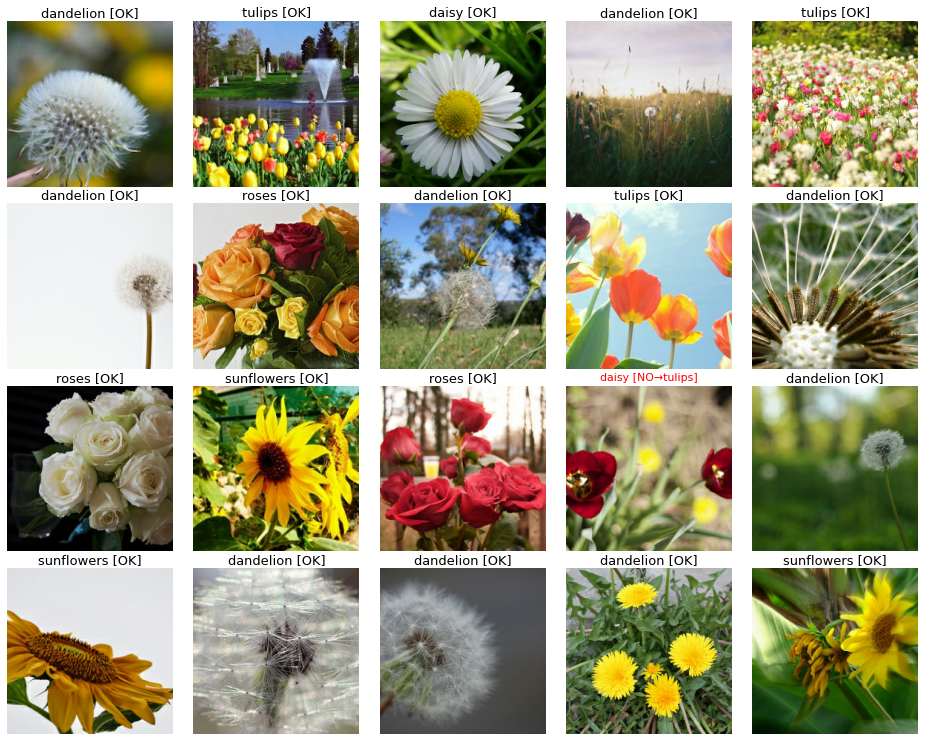

In [ ]:

# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)